In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression


In [2]:

url = "https://raw.githubusercontent.com/dalgonacoffee/Data102/main/candidate_data3.csv"
df = pd.read_csv(url)

# Data Import + Cleaning

In [3]:
##DO NOT DELETE, IMPORTANT DATA CLEANING

#drop columns
columns_to_drop = [
    'Candidate', 'Race 2', 'Race 3', 'Incumbent Challenger',
    'Runoff Outcome', 'office', 'state',
    'name', 'Party', 'incumbent_challenge', 'Runoff Votes', 'Runoff %', 
    'first_file_date', 'district', 'Congress Type'
]

df = df.drop(columns=columns_to_drop)

df.rename(columns={
    'Race 1': 'Race',
    'clean_name': 'Name',
    'Incumbent': 'Incumbency',
    'candidate_status': 'Statutory',
    'party': 'Party',
    'receipts': 'Receipts',
    'disbursements': 'Disbursements',
    'cash_on_hand_end_period': 'Cash On Hand',
    'debts_owed_by_committee': 'Debts Owed',
    'treatment': 'Treatment',
    'Primary %': 'Vote %'
}, inplace=True)

df = df[df['Primary Outcome'] != 'Made runoff']
df = df[(df['Party'] == 'REP') | (df['Party'] == 'DEM')]
df = df.dropna(subset=['Primary Votes'])

# remove % sign and convert to float
df['Vote %'] = df['Vote %'].str.replace('%', '', regex=False).astype(float)
df['Primary Votes'] = df['Primary Votes'].str.replace(',', '', regex=False).astype(float)

# manually fix rows with wrong data
df.loc[df['Name'] == 'Clifton Vonbuck', ['Vote %', 'Primary Votes']] = [10.2, 9150]
df.loc[df['Name'] == 'Gus Mattammal', ['Vote %', 'Primary Votes']] = [16.5, 23625]
df.loc[df['Name'] == 'Alexander Halter', ['Vote %', 'Primary Votes']] = [1.4, 443]
df.loc[df['Name'] == 'Peter Ohtaki', ['Vote %', 'Primary Votes']] = [12.6, 21354]
df.loc[df['Name'] == 'Chris Champion', ['Vote %', 'Primary Votes']] = [5.6, 5469]

# district = -1 represents non-House elections (senate & governor elections)
df['District'] = df['District'].fillna(-1)

# Keep only Statutory Candidates
df = df[df['Statutory'] == 'C']

In [4]:
# the race column shows both race and ethnicity, so i'm going to simplify it
def simplify_race(race):
    if 'Asian' in race:
        return 'Asian'
    elif 'Black' in race:
        return 'Black'
    elif 'Latino' in race or 'Hispanic' in race:
        return 'Latino'
    elif 'White' in race:
        return 'White'
    elif 'Native' in race:
        return 'Native American'
    elif 'Middle Eastern' in race:
        return 'Middle Eastern'
    elif 'Pacific' in race:
        return 'Pacific Islander'
    elif 'Multiracial' in race:
        return 'Multiracial'
    else:
        return 'Other'

df['Race Grouped'] = df['Race'].apply(simplify_race)
df.drop(columns=['Race'], axis = 1, inplace = True)

# EDA

In [5]:
# display summary statistics of Receipts
df['Receipts'].describe()

count    1.335000e+03
mean     1.924511e+06
std      8.053449e+06
min      0.000000e+00
25%      4.775064e+04
50%      3.321950e+05
75%      1.647513e+06
max      2.065939e+08
Name: Receipts, dtype: float64

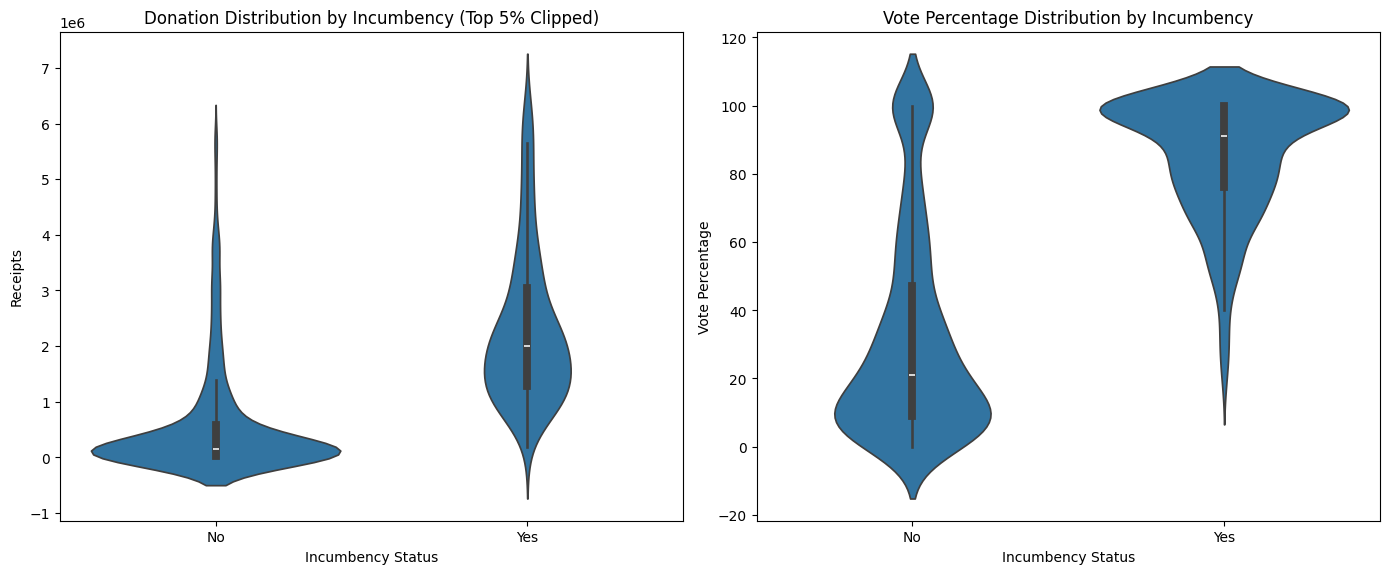

In [6]:
# Filter top 5% outliers for Receipts
percentile_cutoff = 0.95 
cutoff_value = df['Receipts'].quantile(percentile_cutoff)
df_clipped = df[df['Receipts'] <= cutoff_value]

# Create 1 row, 2 column subplot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot: Receipts (Donations)
sns.violinplot(x='Incumbency', y='Receipts', data=df_clipped, ax=axes[0])
axes[0].set_title('Donation Distribution by Incumbency (Top 5% Clipped)')
axes[0].set_xlabel('Incumbency Status')
axes[0].set_ylabel('Receipts')

# Second plot: Vote Percentage
sns.violinplot(x='Incumbency', y='Vote %', data=df, ax=axes[1])
axes[1].set_title('Vote Percentage Distribution by Incumbency')
axes[1].set_xlabel('Incumbency Status')
axes[1].set_ylabel('Vote Percentage')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


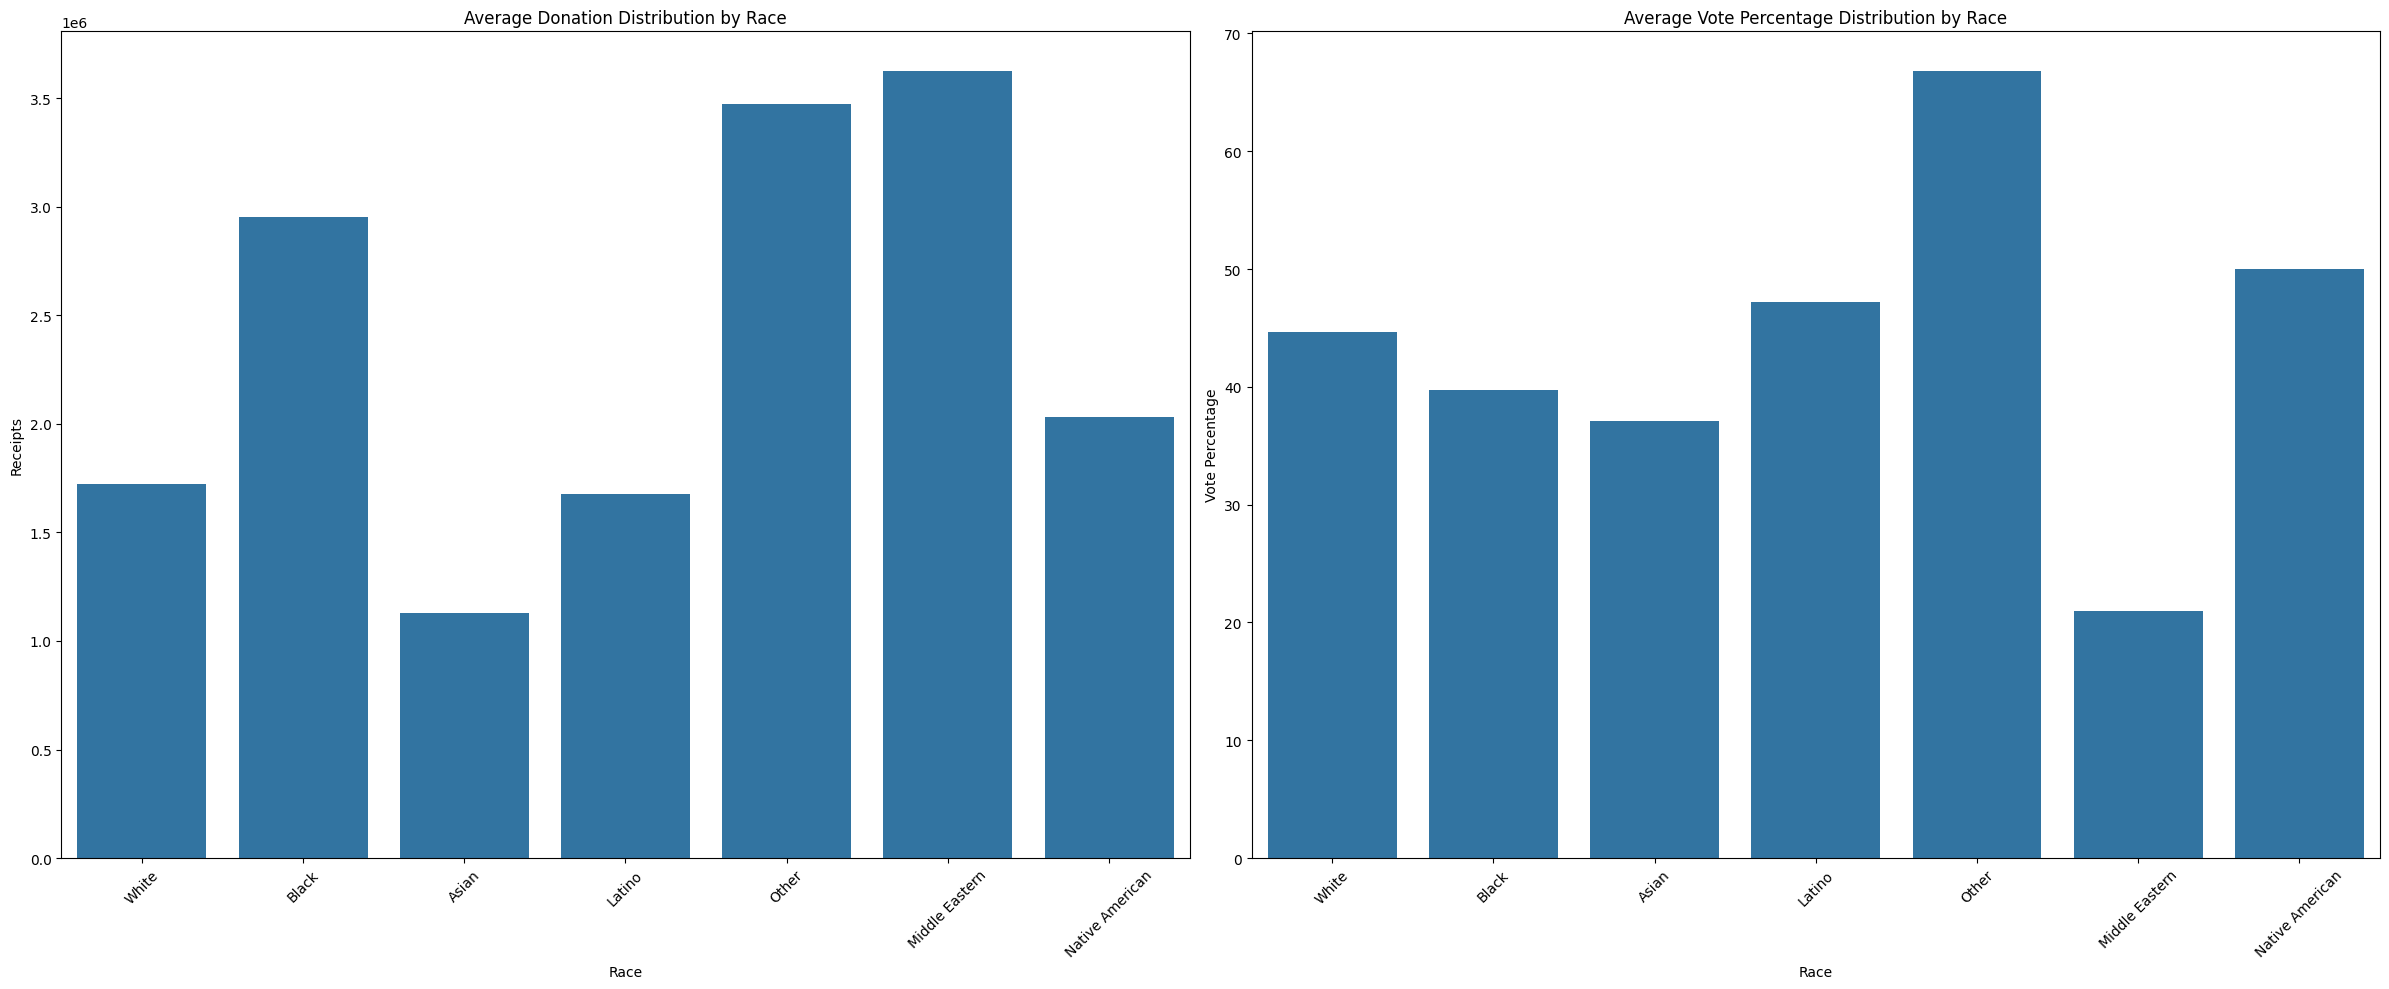

In [7]:
# Create 1 row, 2 column subplot
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Adjust width as needed

# Plot 1: Donation Distribution by Race
sns.barplot(x='Race Grouped', y='Receipts', data=df, ax=axes[0], errorbar=None)
axes[0].set_title("Average Donation Distribution by Race")
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Receipts")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Vote Percentage Distribution by Race
sns.barplot(x='Race Grouped', y='Vote %', data=df, ax=axes[1], errorbar=None)
axes[1].set_title("Average Vote Percentage Distribution by Race")
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Vote Percentage")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


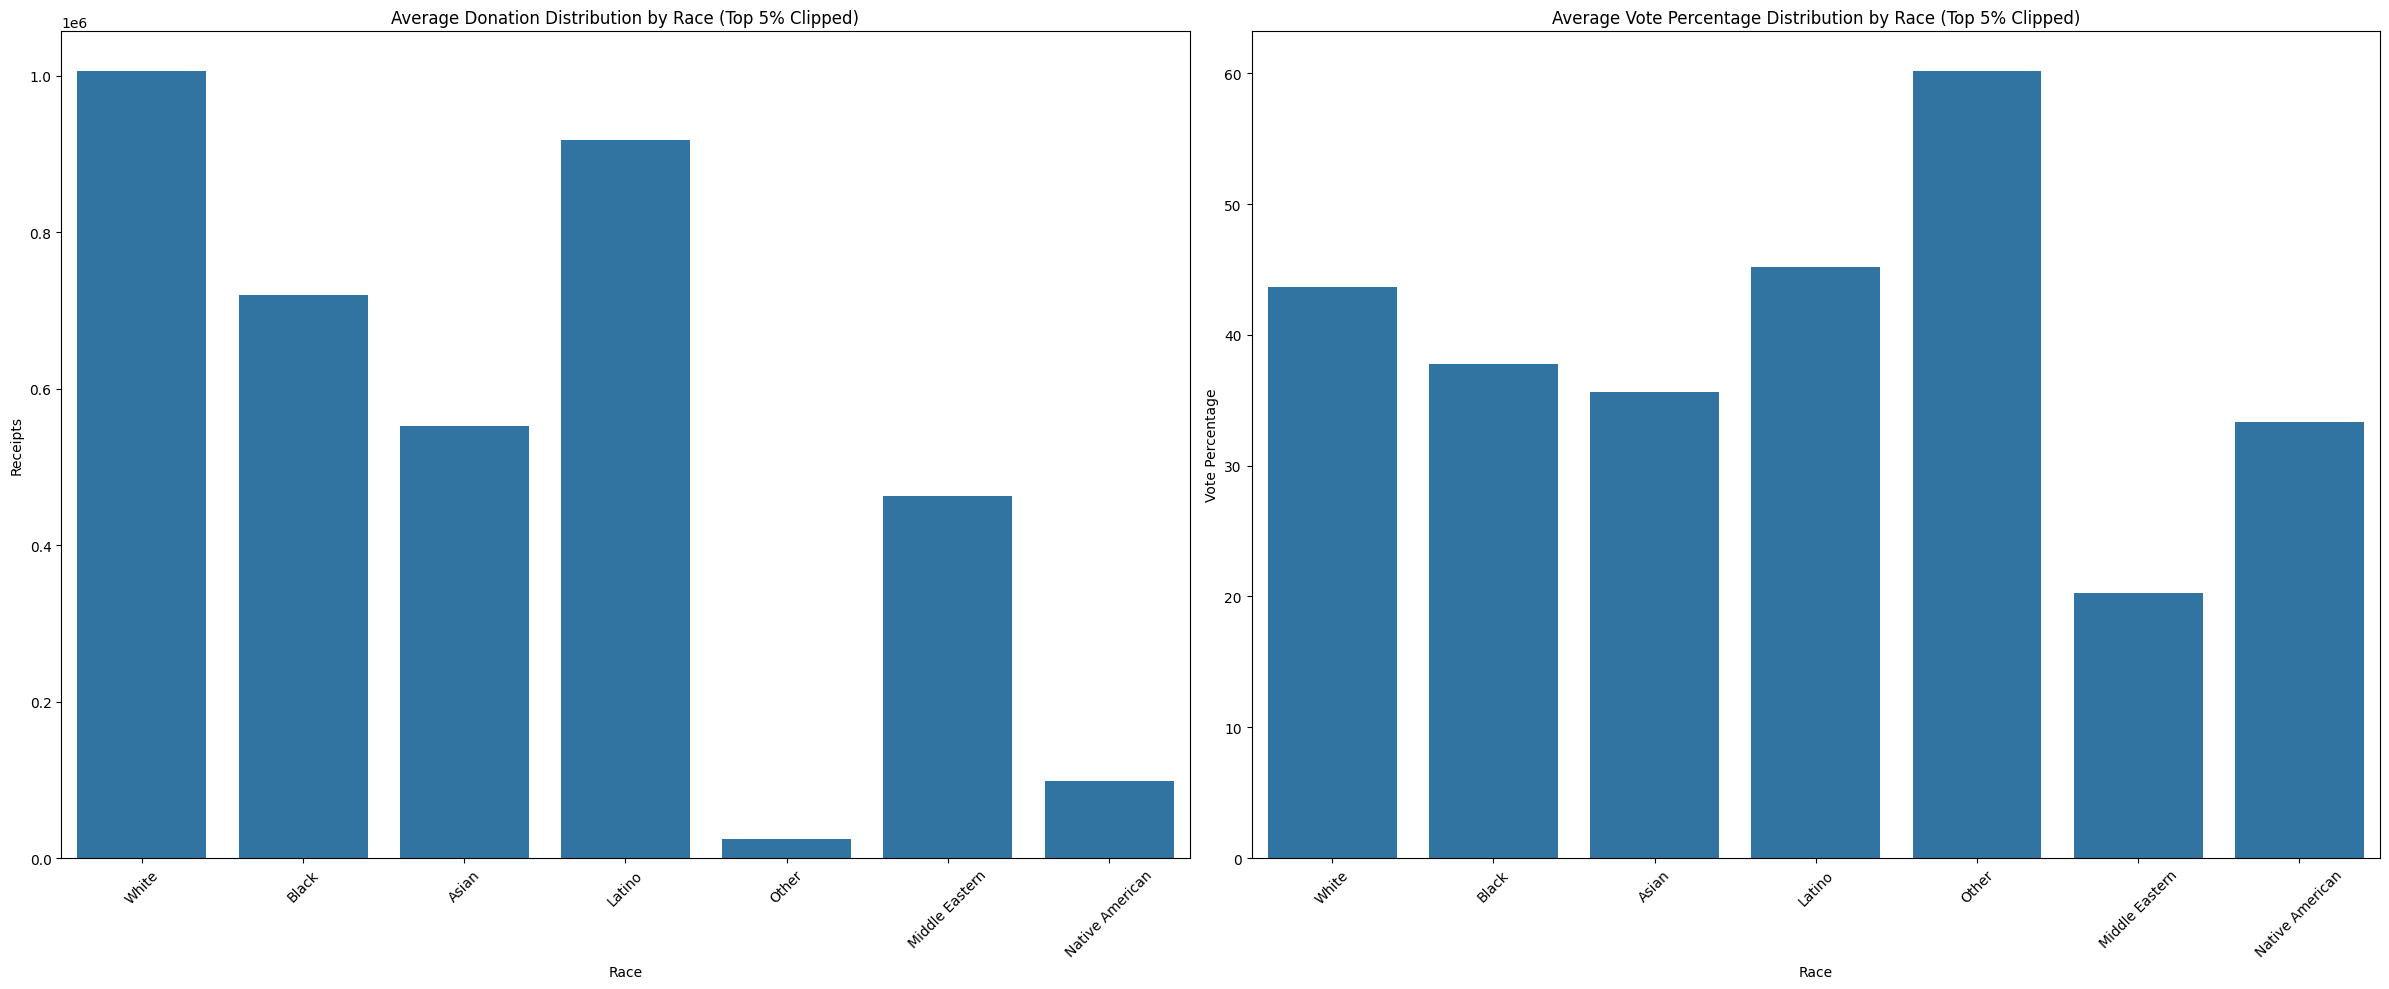

In [8]:
# Create 1 row, 2 column subplot
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Adjust width as needed

# Plot 1: Donation Distribution by Race
sns.barplot(x='Race Grouped', y='Receipts', data=df_clipped, ax=axes[0], errorbar=None)
axes[0].set_title("Average Donation Distribution by Race (Top 5% Clipped)")
axes[0].set_xlabel("Race")
axes[0].set_ylabel("Receipts")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Vote Percentage Distribution by Race
sns.barplot(x='Race Grouped', y='Vote %', data=df_clipped, ax=axes[1], errorbar=None)
axes[1].set_title("Average Vote Percentage Distribution by Race (Top 5% Clipped)")
axes[1].set_xlabel("Race")
axes[1].set_ylabel("Vote Percentage")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [9]:
state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI', 'Idaho': 'ID',
    'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY', 'District of Columbia': 'DC'
}

df["state_abbrev"] = df["State"].map(state_abbrev)


In [10]:
# receipts by state
import plotly.express as px

state_receipts = df.groupby("state_abbrev")["Receipts"].mean().reset_index()

fig = px.choropleth(state_receipts,
                    locations="state_abbrev",
                    locationmode="USA-states",
                    color="Receipts",  
                    scope="usa",
                    color_continuous_scale="Blues",
                    title="Average Receipts by State")
fig.show()

In [11]:
# receipts by state
import plotly.express as px

state_receipts = df.groupby("state_abbrev")["Receipts"].sum().reset_index()

fig = px.choropleth(state_receipts,
                    locations="state_abbrev",
                    locationmode="USA-states",
                    color="Receipts",  
                    scope="usa",
                    color_continuous_scale="Blues",
                    title="Total Receipts by State")
fig.show()

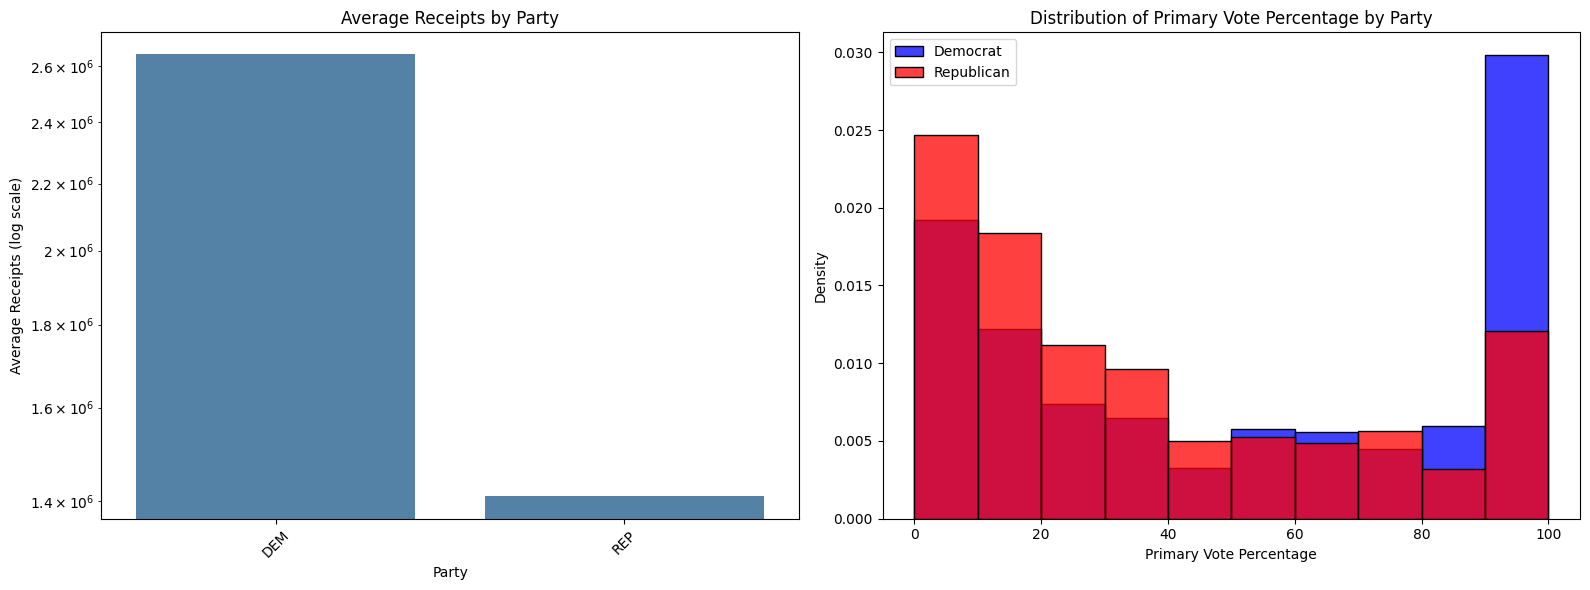

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
grouped = df.groupby("Party")["Receipts"].mean().reset_index()
dem_df = df[df["Party"] == "DEM"]
rep_df = df[df["Party"] == "REP"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average Receipts by Party (log scale)
sns.barplot(data=grouped, x="Party", y="Receipts", color='steelblue', ax=axes[0])
axes[0].set_yscale("log")
axes[0].set_title("Average Receipts by Party")
axes[0].set_xlabel("Party")
axes[0].set_ylabel("Average Receipts (log scale)")
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Vote % Distribution by Party
sns.histplot(data=dem_df["Vote %"], color='blue', bins=10, stat='density', label='Democrat', ax=axes[1])
sns.histplot(data=rep_df["Vote %"], color='red', bins=10, stat='density', label='Republican', ax=axes[1])
axes[1].set_title("Distribution of Primary Vote Percentage by Party")
axes[1].set_xlabel("Primary Vote Percentage")
axes[1].set_ylabel("Density")
axes[1].legend()

# Layout adjustment
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


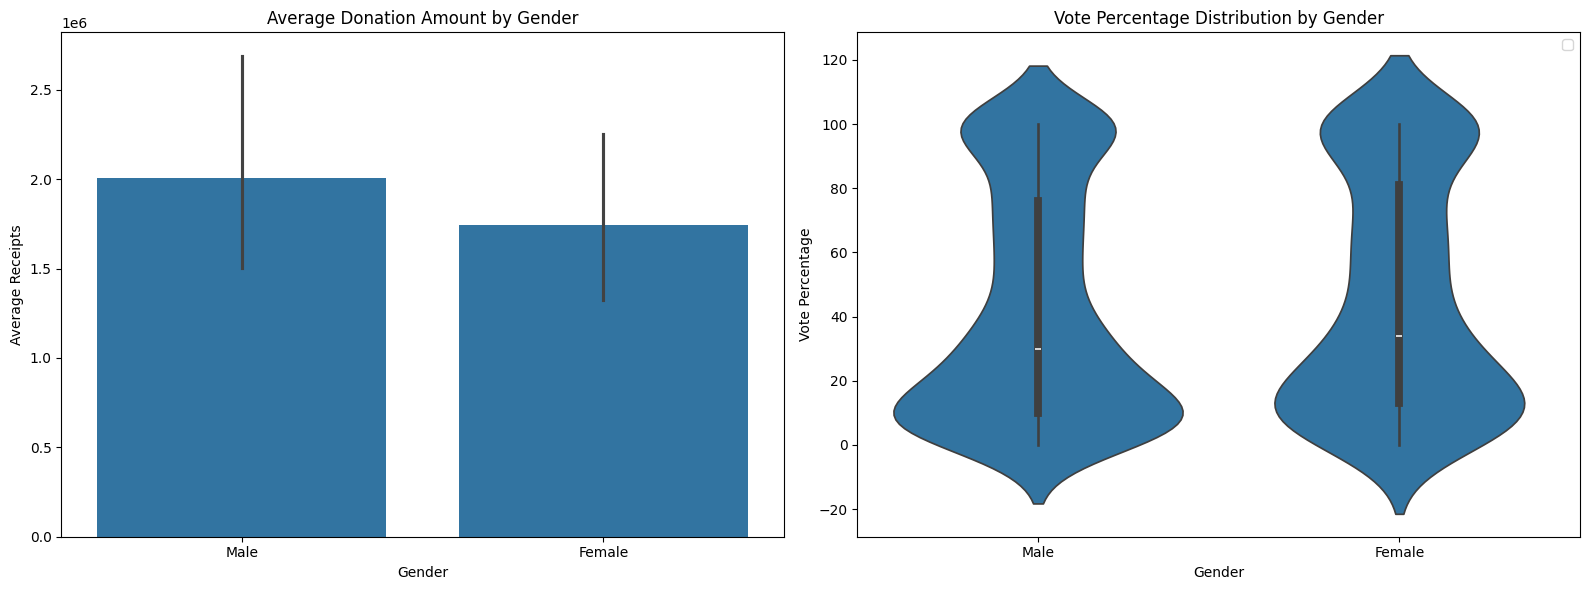

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Average Donation Amount by Gender
sns.barplot(x='Gender', y='Receipts', data=df, ax=axes[0])
axes[0].set_title("Average Donation Amount by Gender")
axes[0].set_xlabel("Gender")
axes[0].set_ylabel("Average Receipts")

# Plot 2: Vote Percentage Distribution by Gender
sns.violinplot(x='Gender', y='Vote %', data=df)
axes[1].set_title("Vote Percentage Distribution by Gender")
axes[1].set_xlabel("Gender")
axes[1].set_ylabel("Vote Percentage")
axes[1].legend()

plt.tight_layout()
plt.show()


/tmp/ipykernel_942/2102146570.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_942/2102146570.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_942/2102146570.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_942/2102146570.py:18: UserWarning:

FixedFormatter should only be used together with FixedLocator



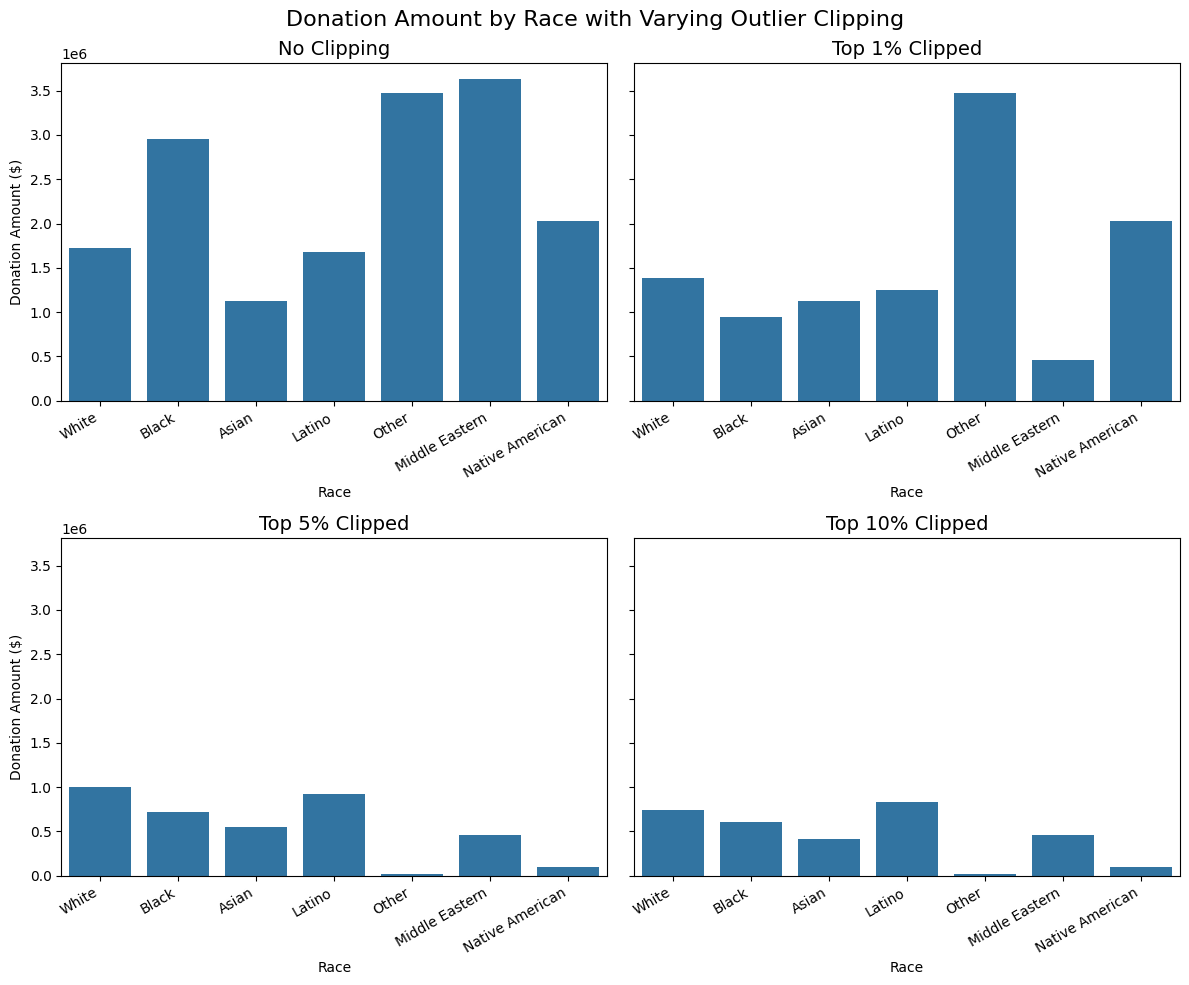

In [14]:
clip_levels = [None, 0.99, 0.95, 0.90]
titles = ['No Clipping', 'Top 1% Clipped', 'Top 5% Clipped', 'Top 10% Clipped']

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
axes = axes.flatten()


for i, clip in enumerate(clip_levels):
    if clip is None:
        df_plot = df.copy()
    else:
        threshold = df['Receipts'].quantile(clip)
        df_plot = df[df['Receipts'] <= threshold]

    sns.barplot(x='Race Grouped', y='Receipts', data=df_plot, ax=axes[i], errorbar=None)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('Race')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=30, ha='right')

    if i % 2 == 0:
        axes[i].set_ylabel('Donation Amount ($)')
    else:
        axes[i].set_ylabel('')

plt.suptitle('Donation Amount by Race with Varying Outlier Clipping', fontsize=16)
plt.tight_layout()
plt.show()

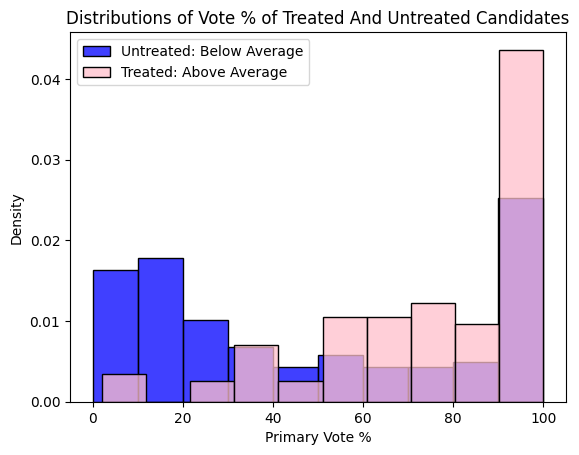

In [15]:
random_candidates = df.groupby(['State', 'District'], group_keys=False).apply(lambda x: x.sample(n=1))

receipts_avg = np.mean(random_candidates['Receipts'])
below_receipts_avg = random_candidates[random_candidates['Receipts'] <= receipts_avg]
above_receipts_avg = random_candidates[random_candidates['Receipts'] > receipts_avg]

sns.histplot(below_receipts_avg['Vote %'], stat='density', color='blue', bins=10, label='Untreated')
sns.histplot(above_receipts_avg['Vote %'], stat='density', color='pink', bins=10, label='Treated')
plt.title("Distributions of Vote % of Treated And Untreated Candidates")
plt.xlabel("Primary Vote %")
plt.legend(labels= ['Untreated: Below Average', 'Treated: Above Average'])
plt.show()

# Causal Inference

In [16]:
url = "https://raw.githubusercontent.com/dalgonacoffee/Data102/main/candidate_data3.csv"
df = pd.read_csv(url)

In [17]:

##DO NOT DELETE, IMPORTANT DATA CLEANING

#drop columns
columns_to_drop = [
    'Candidate', 'Race 2', 'Race 3', 'Incumbent Challenger',
    'Runoff Outcome', 'office', 'state',
    'name', 'Party', 'incumbent_challenge', 'Runoff Votes', 'Runoff %', 'first_file_date', 'district', 'Congress Type'
]

df = df.drop(columns=columns_to_drop)

#rename columns
df = df.rename(columns={
    'Race 1': 'Race',
    'clean_name': 'Name'
})

df = df[df['Primary Outcome'] != 'Made runoff']
df = df[(df['party'] == 'REP') | (df['party'] == 'DEM')]
df = df.dropna(subset=['Primary Votes'])

##manually fix rows
df.loc[df['Name'] == 'Clifton Vonbuck', ['Primary %', 'Primary Votes']] = [10.2, 9150]
df.loc[df['Name'] == 'Gus Mattammal', ['Primary %', 'Primary Votes']] = [16.5, 23625]
df.loc[df['Name'] == 'Alexander Halter', ['Primary %', 'Primary Votes']] = [1.4, 443]
df.loc[df['Name'] == 'Peter Ohtaki', ['Primary %', 'Primary Votes']] = [12.6, 21354]
df.loc[df['Name'] == 'Chris Champion', ['Primary %', 'Primary Votes']] = [5.6, 5469]


df['District'] = df['District'].fillna(-1)
df = df[df['candidate_status'] == 'C']

df['Primary %'] = df['Primary %'].str.replace('%', '', regex=False).astype(float) / 100
df['Primary Votes'] = df['Primary Votes'].str.replace(',', '', regex=False).astype(float)
df['race_grouped'] = df['Race'].apply(simplify_race)

# random candidates
df = df.groupby(['State', 'District'], group_keys=False).apply(lambda x: x.sample(n=1, random_state=50))

In [18]:

df.rename(columns={
    'Incumbent': 'Incumbency',
    'candidate_status': 'Statutory',
    'party': 'Party',
    'receipts': 'Receipts',
    'disbursements': 'Disbursements',
    'cash_on_hand_end_period': 'Cash On Hand',
    'debts_owed_by_committee': 'Debts Owed',
    'race_grouped': 'Race Grouped',
    'treatment': 'Treatment'
}, inplace=True)

In [19]:
receipts_mean = df['Receipts'].mean()
df['Treatment'] = (df['Receipts'] > receipts_mean).astype(int) 

In [20]:
confounders = ['Race Grouped', 'Gender', 'State', 'Incumbency', 'Statutory', 'Party']
def calculate_propensity(data):
    confounders_encoded = pd.get_dummies(data[confounders], columns=confounders, drop_first=True)
    log_reg = LogisticRegression(max_iter=10000)
    log_reg.fit(confounders_encoded, data['Treatment'])
    propensity_scores = log_reg.predict_proba(confounders_encoded)[:, 1]
    return propensity_scores

propensity_scores = calculate_propensity(df)
propensity_scores

array([0.5415377 , 0.06707022, 0.5415377 , 0.10538006, 0.5415377 ,
       0.14137063, 0.14050723, 0.05574467, 0.20961032, 0.20961032,
       0.20961032, 0.41030985, 0.16051282, 0.72672791, 0.20961032,
       0.05431459, 0.78800761, 0.20961032, 0.107538  , 0.107538  ,
       0.107538  , 0.107538  , 0.54716447, 0.13756757, 0.61531714,
       0.65898875, 0.16157318, 0.66072409, 0.16157318, 0.65898875,
       0.16157318, 0.07457289, 0.07457289, 0.72981105, 0.18231095,
       0.13756757, 0.61531714, 0.04006316, 0.13756757, 0.61531714,
       0.13756757, 0.13756757, 0.09910172, 0.21220319, 0.57708722,
       0.04606203, 0.13756757, 0.13848746, 0.65898875, 0.0333918 ,
       0.36907734, 0.13326745, 0.05512042, 0.07457289, 0.13848746,
       0.65898875, 0.53040121, 0.16157318, 0.12199089, 0.0333918 ,
       0.36907734, 0.53040121, 0.0333918 , 0.10314273, 0.61531714,
       0.13756757, 0.13756757, 0.11977815, 0.13756757, 0.13756757,
       0.13848746, 0.13756757, 0.16262332, 0.65898875, 0.14189

In [21]:
def calculate_tau(data, propensity):
    treatment = data['Treatment']
    outcome = data['Primary %']
    tau = np.mean((treatment * outcome / propensity) - ((1 - treatment) * outcome / (1 - propensity)))
    return tau

def bootstrap_tau(data):
    sample = data.sample(n=len(data), replace=True)
    propensity = calculate_propensity(sample)
    estimated_ate = calculate_tau(sample, propensity)
    return estimated_ate

def get_bootstrap_tau(data, n):
    estimates = []
    for i in np.arange(n):
        estimates.append(bootstrap_tau(data))
    return estimates

ates = get_bootstrap_tau(df, 1000)
confidence_interval = [np.percentile(ates, 2.5), np.percentile(ates, 97.5)]
confidence_interval

[-0.05095625432246126, 0.18763090991623985]

In [22]:
def calculate_tau_trimmed(data, propensity):
    copy = data.copy()
    copy.insert(1, 'Propensity', propensity)
    trimmed = copy[(copy['Propensity'] >= 0.1) & (copy['Propensity'] <= 0.9)]
    
    treatment = trimmed['Treatment']
    outcome = trimmed['Primary %']
    trimmed_propensity = trimmed['Propensity']  # Ensure to use the trimmed propensity
    
    tau = np.mean((treatment * outcome / trimmed_propensity) -((1- treatment) * outcome / (1 - trimmed_propensity)))
    return tau

def bootstrap_tau_trimmed(data):
    sample = data.sample(n=len(data), replace=True)
    propensity = calculate_propensity(sample)
    estimated_ate = calculate_tau_trimmed(sample, propensity)
    
    return estimated_ate

def get_bootstrap_tau_trimmed(data, n):
    estimates = []
    for i in range(n):
        estimate = bootstrap_tau_trimmed(data)
        if not np.isnan(estimate):
            estimates.append(estimate)
    return estimates

trimmed_ates = get_bootstrap_tau_trimmed(df, 1000)
confidence_interval = [np.percentile(trimmed_ates, 2.5), np.percentile(trimmed_ates, 97.5)]
confidence_interval

[0.049717194842882326, 0.23673220275337306]

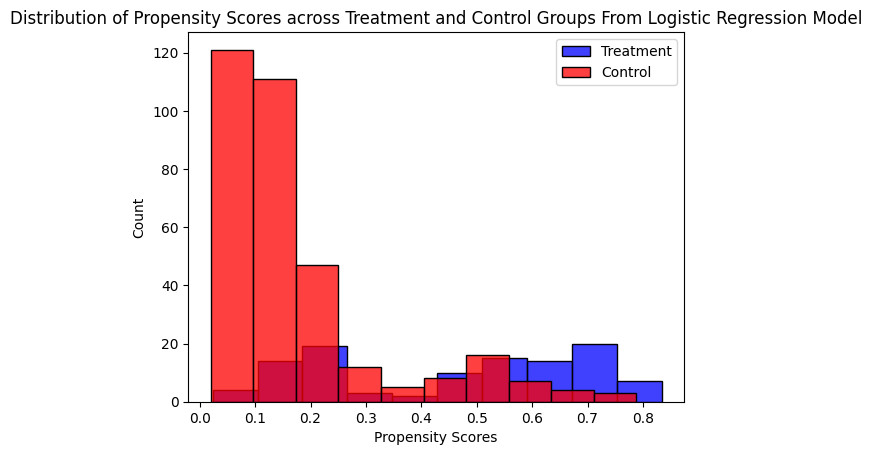

In [23]:
df['Propensity'] = propensity_scores
treatment = df[df['Treatment'] == 1]
control = df[df['Treatment'] == 0]

sns.histplot(treatment['Propensity'], color='blue', bins=10, label='Treatment')
sns.histplot(control['Propensity'], color='red', bins=10, label='Control')

plt.title("Distribution of Propensity Scores across Treatment and Control Groups From Logistic Regression Model")
plt.xlabel("Propensity Scores")
plt.legend()
plt.show()

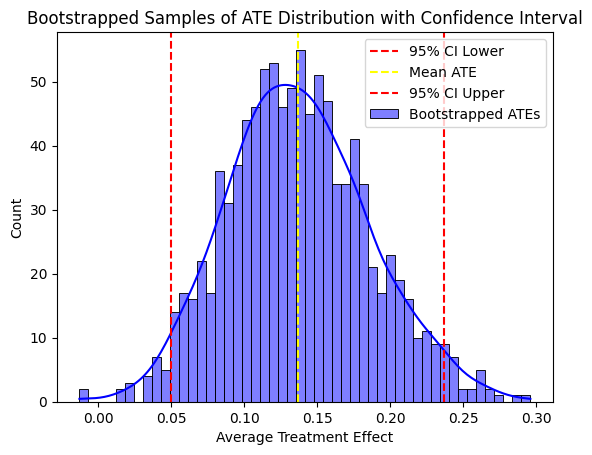

In [24]:
sns.histplot(trimmed_ates, color='blue', bins=50, kde=True, label='Bootstrapped ATEs')

plt.axvline(x=np.percentile(trimmed_ates, 2.5), color='red', linestyle='--', label='95% CI Lower')
plt.axvline(x=np.percentile(np.mean(trimmed_ates), 2.5), color='yellow', linestyle='--', label='Mean ATE')
plt.axvline(x=np.percentile(trimmed_ates, 97.5), color='red', linestyle='--', label='95% CI Upper')
plt.title("Bootstrapped Samples of ATE Distribution with Confidence Interval")
plt.xlabel("Average Treatment Effect")
plt.legend()
plt.show()

# GLM & Nonparametric Models

In [25]:
!pip install statsmodels==0.14.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 17.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [26]:
glm_df = df.copy()

In [27]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [28]:
#binarize outcome Won=1, Lost=0
glm_df['Primary Outcome'] = glm_df['Primary Outcome'].map({'Won': 1, 'Lost': 0})
glm_df['Incumbency'] = glm_df['Incumbency'].map({'Yes': 1, 'No': 0})

## Logistic Regression

In [29]:
glm_df.columns

Index(['Gender', 'Race', 'Incumbency', 'State', 'Office', 'District',
       'Primary Votes', 'Primary %', 'Primary Outcome', 'Name', 'Party',
       'Statutory', 'Receipts', 'Disbursements', 'Cash On Hand', 'Debts Owed',
       'Race Grouped', 'Treatment', 'Propensity'],
      dtype='object')

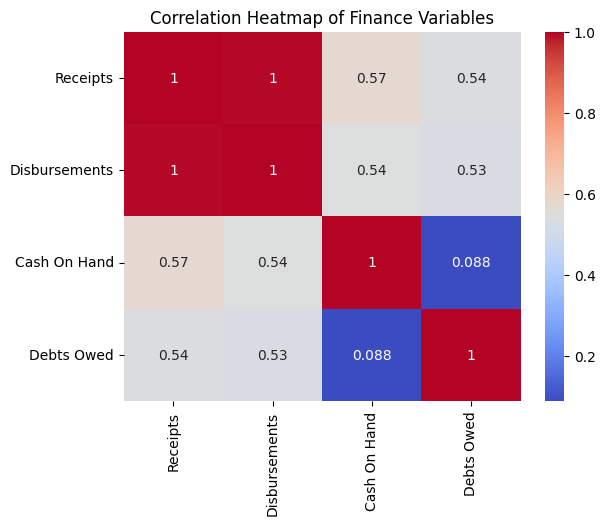

In [30]:
#correlation matrix for numeric columns
corr = glm_df[['Receipts', 'Disbursements', 'Cash On Hand', 'Debts Owed']].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Finance Variables")
plt.show()

In [34]:
#drop disbursements
lr_df = glm_df.drop(columns='Disbursements')

In [37]:
# Define features (X) and target (y)
X = lr_df[['Incumbency', 'Receipts', 'Cash On Hand', 'Debts Owed', 
        'Gender', 'Race Grouped', 'Party']]
y = lr_df['Primary Outcome']

#one hot encode
X = pd.get_dummies(X, columns=['Gender', 'Race Grouped', 'Party'], drop_first=True) 

#convert booleans into float
X = X.astype(float)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y)

# fit the logistic regression model
lr_model = sm.Logit(y_train, X_train)
result = lr_model.fit()

print(result.summary())

         Current function value: 0.443855
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:        Primary Outcome   No. Observations:                  353
Model:                          Logit   Df Residuals:                      341
Method:                           MLE   Df Model:                           11
Date:                Fri, 09 May 2025   Pseudo R-squ.:                  0.3561
Time:                        05:54:18   Log-Likelihood:                -156.68
converged:                      False   LL-Null:                       -243.32
Covariance Type:            nonrobust   LLR p-value:                 2.498e-31
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Incumbency                       0.6324      0.734      0.862      0.389      -0.806       2.071
Receipts   

In [43]:
#AIC for Logistic Regression
result.aic

337.361495097178

In [46]:
#Logistic Regression Model Evaluation
# Predict probability of winning
y_pred_prob = result.predict(X_test)

# Convert probabilities to binary predictions
y_pred_label = (y_pred_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_label))
print("Precision:", precision_score(y_test, y_pred_label))
print("Recall:", recall_score(y_test, y_pred_label))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_prob))

Accuracy: 0.6966292134831461
Precision: 0.8
Recall: 0.5833333333333334
AUC-ROC: 0.8185975609756099


## LASSO Logistic Regression

In [49]:
X = glm_df[['Incumbency', 'Receipts', 'Cash On Hand', 'Debts Owed', 
        'Gender', 'Race Grouped', 'Party', 'State', 'Office', 'Disbursements']]
y = glm_df['Primary Outcome']

# One-hot encode all categorical variables
X = pd.get_dummies(glm_df[['Incumbency', 'Receipts', 'Cash On Hand', 'Debts Owed', 
                       'Gender', 'Race Grouped', 'Party', 'State', 'Office', 'Disbursements']],
                   drop_first=True)

# Convert all to float (needed for sklearn models)
X = X.astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=21, stratify=y)

lasso_model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='f1',
    max_iter=10000,
    random_state=21
)

lasso_model.fit(X_train, y_train)

LogisticRegressionCV(cv=5, max_iter=10000, penalty='l1', random_state=21,
                     scoring='f1', solver='saga')

In [64]:
# Get coefficients from LASSO model
coefficients = pd.Series(lasso_model.coef_[0], index=X.columns)

# Filter to non-zero coefficients
selected = coefficients[coefficients != 0]

print(selected)

Receipts         1.355359e-06
Cash On Hand     4.791783e-06
Debts Owed      -3.043662e-07
Disbursements   -9.969652e-07
dtype: float64


In [67]:
#using default threshold of 0.5
y_prob = lasso_model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.5842696629213483
Precision: 0.5662650602409639
Recall: 0.9791666666666666
AUC-ROC: 0.8572154471544715


In [70]:
#Find proportion of prediction
pd.Series(y_pred).value_counts(normalize=True)

1    0.932584
0    0.067416
Name: proportion, dtype: float64

Note: When using threshold = 0.5, the model almost always predicts 1.

IndexError: index 45 is out of bounds for axis 0 with size 34

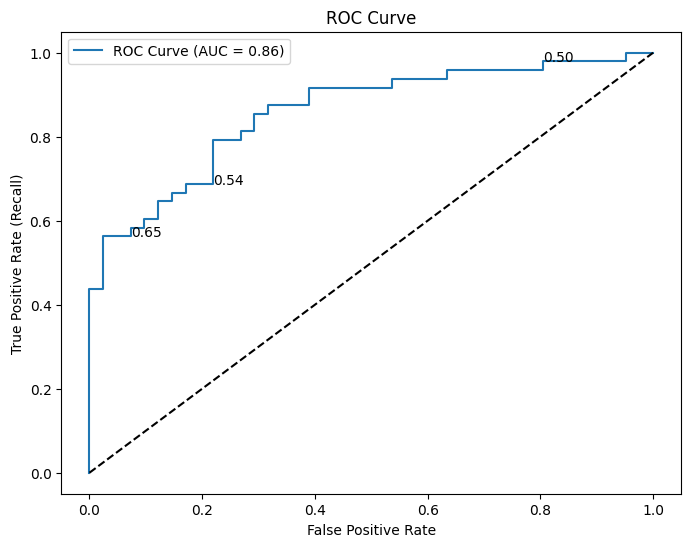

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob)))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()

for i in [5, 15, 30, 45]:  
    plt.annotate(f"{thresholds[i]:.2f}", (fpr[i], tpr[i]))

plt.grid(True)
plt.show()

In [76]:
#using threshold of 0.67
y_prob = lasso_model.predict_proba(X_test)[:, 1]
threshold = 0.67
y_pred_67 = (y_prob >= threshold).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred_67))
print("Precision:", precision_score(y_test, y_pred_67))
print("Recall:", recall_score(y_test, y_pred_67))
print("AUC-ROC:", roc_auc_score(y_test, y_prob))

Accuracy: 0.7415730337078652
Precision: 0.9310344827586207
Recall: 0.5625
AUC-ROC: 0.8572154471544715


In [77]:
pd.Series(y_pred_67).value_counts(normalize=True)

0    0.674157
1    0.325843
Name: proportion, dtype: float64

This shows us that the model is not making as many 1 predictions as the earlier LASSP model.

In [80]:
from sklearn.metrics import log_loss
# Predict probabilities
y_pred_proba = lasso_model.predict_proba(X_test)

# Compute log likelihood (log loss returns average loss)
log_likelihood = -log_loss(y_test, y_pred_proba, normalize=False)

# k = number of parameters (features + intercept)
k = X_train.shape[1] + 1

# Compute AIC
aic = 2 * k - 2 * log_likelihood
print("AIC:", aic)

AIC: 222.2908813202287


# Decision Trees

In [83]:
dt_model = DecisionTreeClassifier(random_state=21, max_depth=4)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_prob_dt = dt_model.predict_proba(X_test)[:, 1] 

print("Decision Tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_dt))

Decision Tree:
Accuracy: 0.8202247191011236
Precision: 0.8076923076923077
Recall: 0.875
AUC-ROC: 0.8785569105691057


## Random Forests

In [86]:
# Train
rf_model = RandomForestClassifier(
    n_estimators=100,  # number of trees
    max_depth=6,       # try tuning this
    random_state=21
)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_rf))

Random Forest:
Accuracy: 0.7640449438202247
Precision: 0.8857142857142857
Recall: 0.6458333333333334
AUC-ROC: 0.8765243902439025


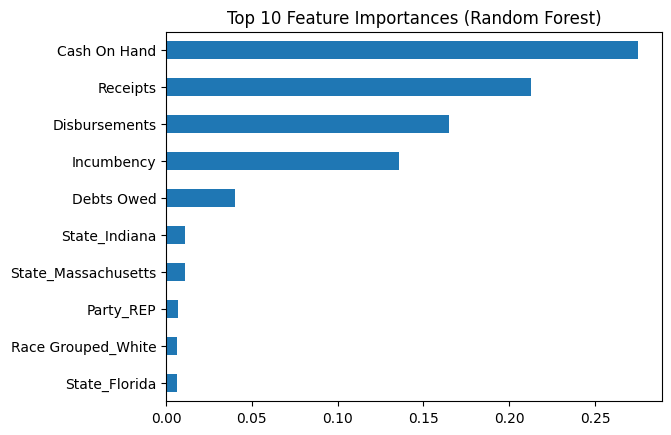

In [89]:
#Plot feature importances
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances.sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

In [92]:
importances.sort_values().tail(10).index.tolist()

['State_Florida',
 'Race Grouped_White',
 'Party_REP',
 'State_Massachusetts',
 'State_Indiana',
 'Debts Owed',
 'Incumbency',
 'Disbursements',
 'Receipts',
 'Cash On Hand']

## K-NN

In [95]:
# Train
knn_model = KNeighborsClassifier(n_neighbors=5)  # try k=3, 5, 7
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

print("k-NN:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("AUC-ROC:", roc_auc_score(y_test, y_prob_knn))

k-NN:
Accuracy: 0.7078651685393258
Precision: 0.7291666666666666
Recall: 0.7291666666666666
AUC-ROC: 0.8089430894308942


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd8b95a0-15e0-4a01-adf7-04b48b22a60e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>